In [1]:
import pandas as pd
import requests
import json

In [3]:
# Fake tokens. Generate your own and replace these
token_list = ["NlC2UqLrrrkMjmlFdmujndrvLY3a3VAM93MJSLU",
                "z1eMpRHjjjr5P1CDBQg80eYnEKHSKXEzx1H1QPN",
                "m2YCbnUVoooTVVro8MV3UOJ8pGmIxBA3o389GDQ"]



SyntaxError: invalid syntax (<ipython-input-3-628ebd25f90d>, line 3)

In [3]:
'''
@url Github API URL for extracting the
@token_list a list of GitHub tokens
@ct token counter
'''
def get_response(url, token_list, ct):
    jsonData = None

    len_tokens = len(token_list)
    try:
        ct = ct % len_tokens
        headers = {'Authorization': 'Bearer {}'.format(token_list[ct])}
        request = requests.get(url, headers=headers)
        jsonData = json.loads(request.content)
        ct += 1
    except Exception as e:
        ct += 1
        print(e)
    return jsonData, ct


In [4]:
# Sample repository. Replace it with your own repository
reponame = 'python-babel/flask-babel'
contribution = ['PR', 'PR-reviews', 'changedFileCount', 'changedLOC', 'Issues', 'Issue-comments']
ct = 0

In [5]:
# This function returns the a list of contributor's names and login-names
def contributors(reponame, token_list, ct):
    contributor_names = []
    contributor_logins = []

    api = 'https://api.github.com/repos/' + reponame + '/contributors'

    try:
        contributor_array, ct = get_response(api, token_list, ct)

        if contributor_array is not None:
            for contributor_obj in contributor_array:
                contributor_name = ''
                contributor_logins.append(contributor_obj['login'])
                contributor_api = 'https://api.github.com/users/' + contributor_obj['login']
                contributor_obj2, ct = get_response(contributor_api, token_list, ct)
                if contributor_obj2 is not None:
                    contributor_name = contributor_obj2['name']
                contributor_names.append(contributor_name)

    except Exception as e:
        print(e)
    # print(contributor_logins)
    return contributor_names, contributor_logins, ct

contributor_names, contributor_logins, ct = contributors(reponame, token_list, ct)
print('Number of Repository contributors', len(contributor_logins))

29


In [55]:
# This function takes in the contributor list returned in the
# previous cell

def pullrequest_details(reponame, contributor_logins, token_list, ct):
    contributor_pr_count = dict()
    contributor_changedFiles_count = dict()
    contributor_changedLOC = dict()
    contributor_pr_review_count = dict()

    try:
        # loop though all the commit pages until the last returned empty page
        ipage = 0
        while True:
            spage = str(ipage)
            pr_api = 'https://api.github.com/repos/' + reponame + '/pulls?page=' + spage + \
                     '&per_page=100&state=all'
            pr_array, ct = get_response(pr_api, token_list, ct)

            # break out of the while loop if there are no more commits in the pages
            if len(pr_array) == 0:
                break
            for contri_login in contributor_logins:
                # iterate through the list of pull requests in  spage
                for pr_obj in pr_array:
                    pr_number = pr_obj['number']
                    login = pr_obj['user']['login']
                    if login is not None:
                            if contri_login == login:
                                contributor_pr_count[login] = contributor_pr_count.get(login, 0) + 1
                                pr_reviews_api = 'https://api.github.com/repos/' + reponame + '/pulls/' \
                                                 + str(pr_number) + '/reviews'
                                pr_reviews_array, ct = get_response(pr_reviews_api, token_list, ct)
                                if len(pr_reviews_array) != 0:
                                    for pr_review_obj in pr_reviews_array:
                                        reviewer_login = pr_review_obj['user']['login']
                                        if contri_login == reviewer_login:
                                            contributor_pr_review_count[login] = contributor_pr_count.\
                                                                                     get(login, 0) + 1
                                pr_changedFiles_api = 'https://api.github.com/repos/' + reponame + '/pulls/' \
                                                 + str(pr_number) + '/files'
                                pr_changedFiles_array, ct = get_response(pr_changedFiles_api, token_list, ct)
                                contributor_changedFiles_count[login] = contributor_changedFiles_count.get(login, 0) \
                                                                        + len(pr_changedFiles_array)
                                for pr_changedFile_obj in pr_changedFiles_array:
                                    contributor_changedLOC[login] = contributor_changedLOC.get(login, 0) \
                                                                        + pr_changedFile_obj['changes']

            ipage += 1
    except:
        print("Error receiving data")
        exit(0)

    return contributor_pr_count, contributor_pr_review_count,\
           contributor_changedFiles_count, contributor_changedLOC, ct

contributor_pr_count, contributor_pr_review_count,\
           contributor_changedFiles_count, contributor_changedLOC, ct = \
    pullrequest_details(reponame, contributor_logins, token_list, ct)

In [62]:
# This function processes the issue details of a repository
def issue_details(reponame, contributor_logins, token_list, ct):
    contributor_issue_count = dict()
    contributor_comment_count = dict()

    try:
        # loop though all the commit pages until the last returned empty page
        ipage = 0
        while True:
            spage = str(ipage)
            issue_api = 'https://api.github.com/repos/' + reponame + '/issues?state=all&' \
                                                                     'per_page=100&page=' + spage

            issue_array, ct = get_response(issue_api, token_list, ct)

            # break out of the while loop if there are no more commits in the pages
            if len(issue_array) == 0:
                break
            # iterate through the list of pull requests in  spage
            for contri_login in contributor_logins:
                for issue_obj in issue_array:
                    issue_number = issue_obj['number']
                    # print(issue_number)
                    login = issue_obj['user']['login']
                    # print(login)
                    if login is not None:
                            if contri_login == login:
                                contributor_issue_count[login] = contributor_issue_count.get(login, 0) + 1
                                issue_comments_api = 'https://api.github.com/repos/' + reponame + '/issues/' \
                                                 + str(issue_number) + '/comments'
                                issue_comment_array, ct = get_response(issue_comments_api, token_list, ct)
                                if len(issue_comment_array) != 0:
                                    for issue_comment_obj in issue_comment_array:
                                        commenter_login = issue_comment_obj['user']['login']
                                        if contri_login == commenter_login:
                                            contributor_comment_count[login] = contributor_comment_count.\
                                                                                     get(login, 0) + 1

            ipage += 1
    except:
        print("Error receiving data")

    return contributor_issue_count, contributor_comment_count, ct
contributor_issue_count, contributor_comment_count, ct = \
    issue_details(reponame, contributor_logins, token_list, ct)

In [63]:
df_pr = pd.DataFrame(contributor_pr_count.items(), columns = ['Login','PRs'])
df_prReviews = pd.DataFrame(contributor_pr_review_count.items(), columns = ['Login','PR-Reviews'])
df_pr_ChangedFiles = pd.DataFrame(contributor_changedFiles_count.items(), columns = ['Login','ChangedFiles'])
df_pr_ChangedLOC = pd.DataFrame(contributor_changedLOC.items(), columns = ['Login','ChangedLOC'])
df_issues = pd.DataFrame(contributor_issue_count.items(), columns = ['Login','Issues'])
df_issues_comments = pd.DataFrame(contributor_comment_count.items(), columns = ['Login','Issues_comments'])

In [78]:
from functools import reduce

df_list = [df_pr, df_prReviews, df_issues, df_issues_comments, df_pr_ChangedFiles,df_pr_ChangedLOC]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Login'],
                                            how='outer'), df_list)
df_merged = df_merged.fillna(0).sort_values('ChangedLOC', ascending=[0])
df_merged = df_merged.head(25)
df_merged.sort_index(inplace=True)
df_merged = df_merged.head(10)

         Login  PRs  PR-Reviews  Issues  Issues_comments  ChangedFiles  \
0       TkTech    8         NaN      12              NaN            48   
1  ThiefMaster    4         NaN       6              7.0            36   
2       DasIch    8         NaN       4              NaN            24   
3   Bernardoow    2         3.0       4              NaN             2   
4          dag    2         NaN       2              2.0             8   

   ChangedLOC  
0        2590  
1        2472  
2         148  
3         138  
4         140  


<Figure size 640x480 with 0 Axes>

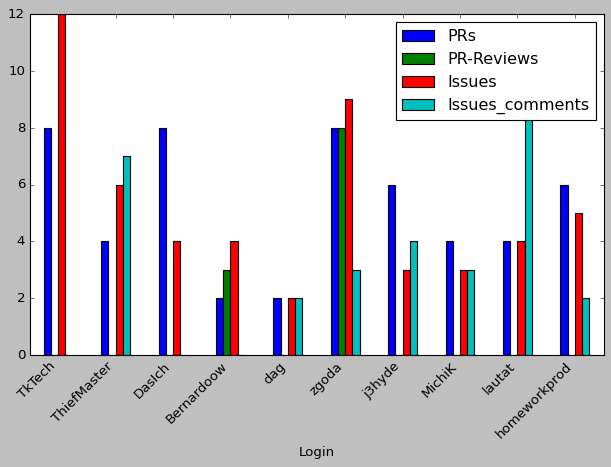

In [87]:
# Replace the login names with your real names in the report

import matplotlib.pyplot as plt
fig = plt.figure()

plt.style.use('classic')
ax = df_merged.plot(x="Login", y=["PRs", "PR-Reviews", "Issues", "Issues_comments"], kind="bar", rot=45)
plt.tight_layout()
plt.show()
# plt.savefig('../img/contributions.pdf')

<Figure size 640x480 with 0 Axes>

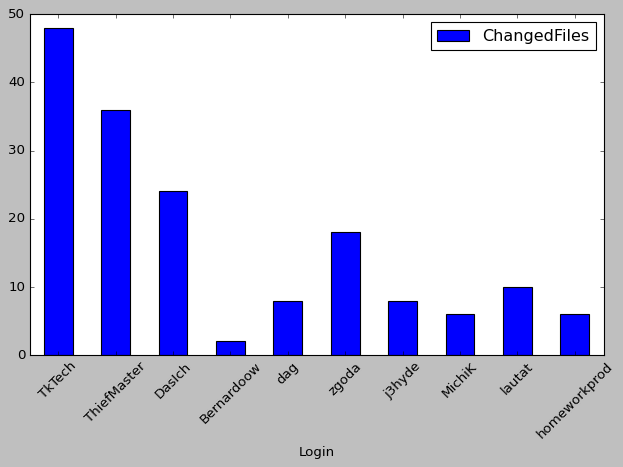

In [85]:
plt.style.use('classic')
ax = df_merged.plot(x="Login", y=["ChangedFiles"], kind="bar", rot=45)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

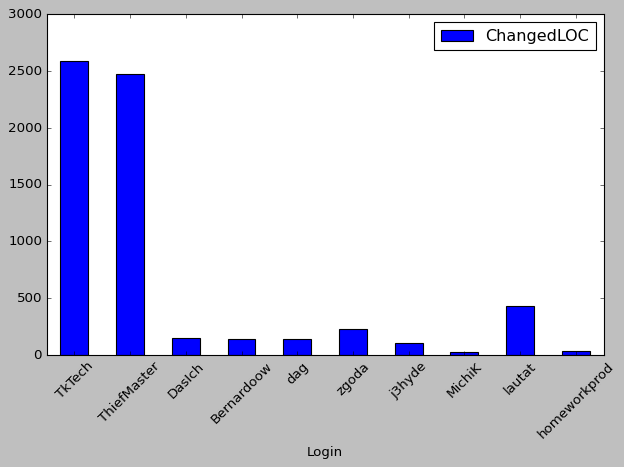

In [86]:
fig = plt.figure()

plt.style.use('classic')
ax = df_merged.plot(x="Login", y=["ChangedLOC"], kind="bar", rot=45)
plt.tight_layout()
plt.show()